In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
import os
from joblib import Parallel, delayed


# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

from macd import MACD, DUAL_MACD,  compute_portfolio, run_macd_hyperparam_search, run_macd_hyperparam_search_with_regimes, generate_position
from momentum import SMA, EMA, evaluate_momentum_params, run_momentum_hyperparam_search
from performance_metrics import compute_performance_metrics
from supervised_learning import (
    SupervisedLearning,
    create_all_features,
    make_future_log_return,
    make_direction_label
)
from feature_engineering import create_all_features
from regime_clustering import compute_regime_clusters, assign_regimes

from utils import plot_cumulative_returns

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lets_plot import *
LetsPlot.setup_html()

#  <a id = "top"> Table of Contents </a> 

## <font color = blue>[Part 1 - Trading Strategies](#part1)

> Building trading stragies with spy as tradeable Assets
### [1.1 Buy and Hold](#part11)
### [1.2 Baseline MACD](#part12)
### [1.3 Tuned MACD](#part13)
### [1.4 Vol Clustering with MACD](#part14)
### [1.5 SMA (Tuned)](#part15)
### [1.6 Dual MACD](#part16)
### [1.7 SL (Daily Returns)](#part17)
### [1.8 EMA (Tuned)](#part18)


## [Part 2 - Results of Strategies](#part2)

> Visualize results of strategies

## [Part 3 - Executive Summary](#part3)

> Reviewing strategies and backtest results

## [Part 4 - Self-Critique](#part4)

>  dissect and scrutinize our strategies through the lens of common biases and potential market shifts

## [Part 5 - Contribution Statement](#part5)

## <a id = "part1"></a><font color = blue> 👉 Part 1 - Trading strategies</font> [back to table of contents](#top) 

## Exploratory Data Analysis

In [4]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12

In [5]:
spy =\
(
    yf.
    download(
        "SPY",
        start = start_date,
        end = end_date
    )
)

spy.columns =\
(
    spy
    .columns
    .droplevel(1) # level 0 --> Price; level 1 --> Ticker
)

spy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973618,96.990434,95.875442,96.927323,83005600
2006-11-02,95.917496,96.078781,95.622970,95.728154,60693100
2006-11-03,95.749176,96.345246,95.104024,96.261099,71346400
2006-11-06,96.829163,96.969411,96.036742,96.043761,63303300
2006-11-07,97.200867,97.460327,96.773101,96.913350,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900


In [6]:
df = spy.copy()

## Add Predictions

We transform future returns into predictive labels and train ML models to classify up/down movements, which later act as a filter for momentum trades.

In [7]:
Y_reg = make_future_log_return(spy, price_column="Close", horizon=1)
Y_clf = make_direction_label(Y_reg)   # 1 if up, 0 if down

In [8]:
X = create_all_features(
    spy,
    lagged_return_periods=[1,2,3,5,10],
    vol_periods=[20,60],
    sma_periods=[20,60],
    ema_periods=[10,30],
    rsi_periods=[10,30],
    stok_periods=[14],
    stod_periods=[3],
    roc_periods=[10],
    atr_periods=[5,14]
)


In [9]:
data = pd.concat([Y_clf, X], axis=1).dropna()

Y = data[Y_clf.name]
X = data[X.columns]

SL = SupervisedLearning()

X_train, X_test, Y_train, Y_test = SL.sequential_split(X, Y, train_frac=0.75)

Sequential Split: 3546 train / 1183 test samples


In [10]:
results = SL.run_all_classifiers(X_train, Y_train, X_test, Y_test)
results

Logistic: accuracy=0.5571
RandomForest: accuracy=0.4607
GradientBoosting: accuracy=0.4565
KNN_Classifier: accuracy=0.4937


,Model,Accuracy
0,Logistic,0.557058
1,RandomForest,0.460693
2,GradientBoosting,0.456467
3,KNN_Classifier,0.493660


In [11]:
result = SL.tune_probability_threshold(
    model = SL.get_classifier_by_name('Logistic'),
    X_train = X_train,
    y_train = Y_train,
    X_test  = X_test,
    y_test  = Y_test,
    thresholds = np.arange(0.50, 0.80, 0.01),
    return_metric="sharpe"
)

result["best_threshold"]
result["threshold_cv_results"].head()


Best Threshold = 0.500
threshold          0.500000
train_sharpe      17.033682
test_sharpe       16.736577
train_accuracy     0.554992
test_accuracy      0.557058
Name: 0, dtype: float64


,threshold,train_sharpe,test_sharpe,train_accuracy,test_accuracy
0,0.50,17.033682,16.736577,0.554992,0.557058
1,0.51,16.642944,16.344413,0.556966,0.556213
2,0.52,15.782998,15.694373,0.553582,0.546915
3,0.53,14.351283,15.069640,0.547941,0.540997
4,0.54,12.609164,14.173703,0.540609,0.534235


In [12]:
clf = result["model"]
best_th = result["best_threshold"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Probability SPY goes UP
p_train = clf.predict_proba(X_train_scaled)[:, 1]
p_test  = clf.predict_proba(X_test_scaled)[:, 1]
train_pred = (p_train > best_th).astype(int)
test_pred  = (p_test > best_th).astype(int)

In [13]:
df.loc[X_train.index, "ml_prob"] = p_train
df.loc[X_train.index, "ml_signal"] = train_pred

df.loc[X_test.index, "ml_prob"] = p_test
df.loc[X_test.index, "ml_signal"] = test_pred

# df = df.bfill() # just to complet the ml prob and ml signal accoridng

In [14]:
df.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal
Date,,,,,,,
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0
2025-11-11,683.000000,683.570007,678.729980,679.950012,58953400,0.610358,1.0
2025-11-12,683.380005,684.960022,680.950012,684.789978,62312500,0.608380,1.0


### Passive Returns

In [15]:
split_idx = int(len(df) * 0.75)

df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

In [ ]:
def generate_passive_returns(df: pd.DataFrame):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df['Close']
            /
            df['Close'].shift(1)
            )
    )

    df['cumulative_passive_returns'] =\
    (
        np.exp(
            df['passive_returns']
            .fillna(0)
            .cumsum()
        )
    )
    return df

In [17]:
df_train = generate_passive_returns(df_train)
df_test = generate_passive_returns(df_test)

In [18]:
def plot_returns(df, y,
                date_column = 'Date',
                returns_column = 'cumulative_passive_returns'):
    
    melted = (
        df[[date_column, returns_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={returns_column: "blue"})
        + labs(
            title="Cumulative Returns",
            x="Date",
            y=y,
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [19]:
plot_returns(
    df=df_train.reset_index(),
    y='Training Returns'
)

In [20]:
plot_returns(
    df=df_test.reset_index(),
    y='Testing Returns'
)

In [21]:
(
    df_test['ml_signal']
    .value_counts()
)

ml_signal
1.0    1138
0.0      59
Name: count, dtype: int64

<Axes: xlabel='Date'>

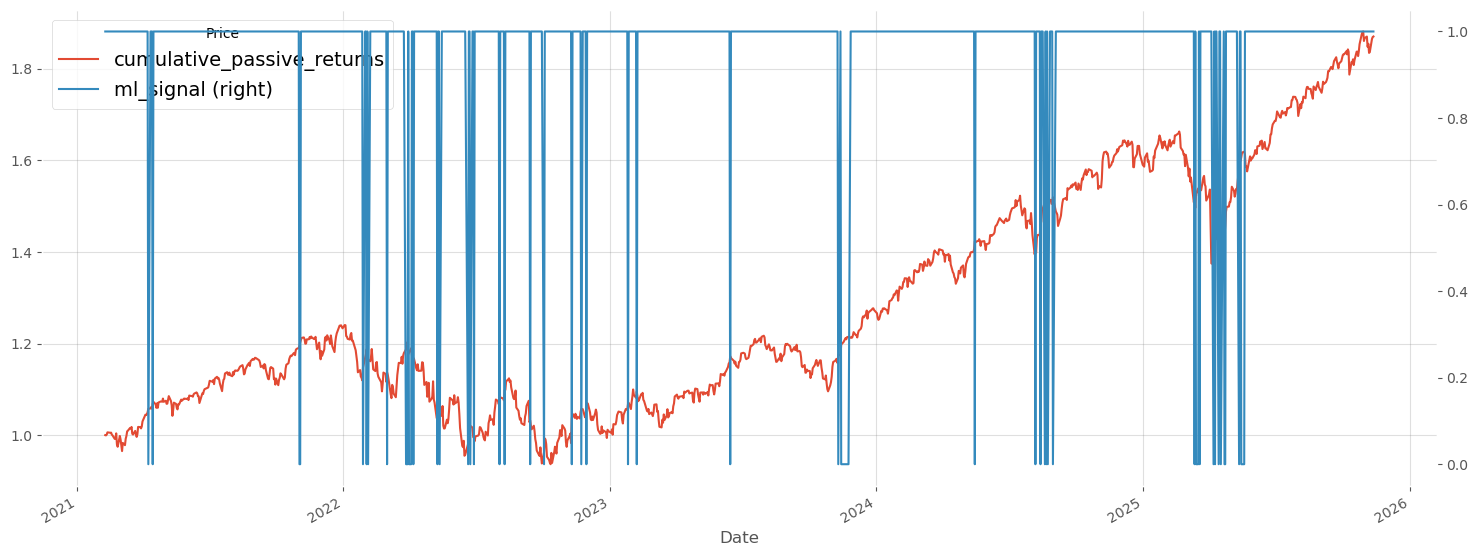

In [22]:
(
    df_test[['cumulative_passive_returns','ml_signal']]
    .plot(secondary_y = "ml_signal",
          figsize = [18, 7]
         )
)

# Individual Strategies

In [23]:
starting_capital = 100_000.0

In [24]:
combined_results = []

In [25]:
df_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns
Date,,,,,,,,,
2021-02-09,365.365479,365.964682,364.354358,364.766275,35551100,0.561384,1.0,NaN,1.000000
2021-02-10,365.206451,367.266179,362.790978,367.116378,59154400,0.542513,1.0,-0.000435,0.999565
2021-02-11,365.796265,366.713785,363.352706,366.292468,42913300,0.551159,1.0,0.001614,1.001179
2021-02-12,367.603210,367.846612,364.916193,364.991108,50593300,0.533410,1.0,0.004928,1.006125
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,0.553147,1.0,-0.000866,1.005253
...,...,...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091


## <a id = "part11"></a> 1.1 Buy and Hold [back to table of contents](#top) 

In [26]:
buy_and_hold = \
(
    compute_performance_metrics(
        log_returns=df_test['passive_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Buy and Hold'
    )
)
print(buy_and_hold)

               CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Buy and Hold  0.141       0.173         0.245          0.85          1.403   

              Calmar Ratio  Final Portfolio Value  Cumulative Return  
Buy and Hold         0.574             187040.113               1.87  


In [27]:
combined_results.append(buy_and_hold)

## <a id = "part12"></a> 1.2 Baseline MACD [back to table of contents](#top) 

In [28]:
baseline_macd = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=False)
baseline_macd = compute_portfolio(
    df = baseline_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,12_ewma,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629,676.597220,...,NaN,0.0,122363.859222,0.0,-1.0,0.0,0.0,122363.859222,-0.010755,1.223639
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435,675.731489,...,NaN,0.0,122363.859222,0.0,0.0,0.0,0.0,122363.859222,0.000000,1.223639
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091,676.609722,...,NaN,0.0,122363.859222,0.0,0.0,0.0,0.0,122363.859222,0.000000,1.223639
2025-11-11,683.000000,683.570007,678.729980,679.950012,58953400,0.610358,1.0,0.002287,1.869361,677.592842,...,NaN,0.0,122363.859222,0.0,0.0,0.0,0.0,122363.859222,0.000000,1.223639
2025-11-12,683.380005,684.960022,680.950012,684.789978,62312500,0.608380,1.0,0.000556,1.870401,678.483174,...,NaN,0.0,122363.859222,0.0,0.0,0.0,0.0,122363.859222,0.000000,1.223639


In [29]:
baseline_macd_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Base)'
    )
)

In [30]:
combined_results.append(baseline_macd_metric)

## <a id = "part13"></a> 1.3 Tuned MACD [back to table of contents](#top) 

In [31]:
results = []
short_choices = np.linspace(6, 20, 10).astype(int).tolist()
long_choices = np.linspace(20, 60, 10).astype(int).tolist()
signal_choices = np.linspace(5, 20, 10).astype(int).tolist()
allow_short = False

# ---- CREATE TASK LIST ----
macd_task_list = [
    (short_ma, long_ma, signal)
    for short_ma in short_choices
    for long_ma in long_choices
    if long_ma > short_ma
    for signal in signal_choices
]

In [32]:
macd_hyperparam_df =\
(
    run_macd_hyperparam_search(
        df = df_train,
        price_col='Close',
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=allow_short,
        cache_file="data/macd_tuned_with_signal.csv",
        signal_check=True
    )
)
macd_hyperparam_df

Loaded cached results from: data/macd_tuned_with_signal.csv


,short_ma,long_ma,signal,regime,cumulative_return,sharpe
0,10,42,6,NaN,3.453832,0.435714
1,6,42,10,NaN,3.453832,0.435714
2,7,46,8,NaN,3.449169,0.434631
3,10,46,6,NaN,3.447602,0.432060
4,9,55,6,NaN,3.447602,0.432060
...,...,...,...,...,...,...
985,18,55,20,NaN,1.890883,0.240286
986,18,60,18,NaN,1.890883,0.240286
987,20,60,16,NaN,1.890883,0.240286
988,16,60,20,NaN,1.890883,0.240286


In [33]:
best_row =\
(
    pd.DataFrame(macd_hyperparam_df)
        .sort_values("cumulative_return", ascending=False)
).iloc[0]

best_row

short_ma             10.000000
long_ma              42.000000
signal                6.000000
regime                     NaN
cumulative_return     3.453832
sharpe                0.435714
Name: 0, dtype: float64

In [34]:
best_span_list = [best_row['short_ma'],best_row['long_ma'],best_row['signal']]
best_span_list


[10.0, 42.0, 6.0]

In [35]:
best_span_macd = MACD(df_test, span=best_span_list, price_col='Close', allow_short=allow_short, signal_check=True)
best_span_macd = compute_portfolio(
    df = best_span_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

best_span_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,10.0_ewma,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629,676.950233,...,NaN,1.0,11.926758,272.0,0.0,0.0,182324.319336,182336.246094,-0.010787,1.823362
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435,675.862912,...,NaN,1.0,11.926758,272.0,0.0,0.0,182503.832031,182515.758789,0.000984,1.825158
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091,676.876929,...,NaN,1.0,11.926758,272.0,0.0,0.0,185351.680664,185363.607422,0.015483,1.853636
2025-11-11,683.000000,683.570007,678.729980,679.950012,58953400,0.610358,1.0,0.002287,1.869361,677.990214,...,NaN,1.0,11.926758,272.0,0.0,0.0,185776.000000,185787.926758,0.002287,1.857879
2025-11-12,683.380005,684.960022,680.950012,684.789978,62312500,0.608380,1.0,0.000556,1.870401,678.970176,...,NaN,1.0,11.926758,272.0,0.0,0.0,185879.361328,185891.288086,0.000556,1.858913


In [36]:
best_span_macd_metric = \
(
    compute_performance_metrics(
        log_returns=best_span_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Tuned)'
    )
)
best_span_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Tuned),0.139,0.173,0.245,0.843,1.391,0.569,185891.288,1.859


In [37]:
combined_results.append(best_span_macd_metric)

## <a id = "part14"></a> 1.4 Vol Clustering with MACD [back to table of contents](#top) 


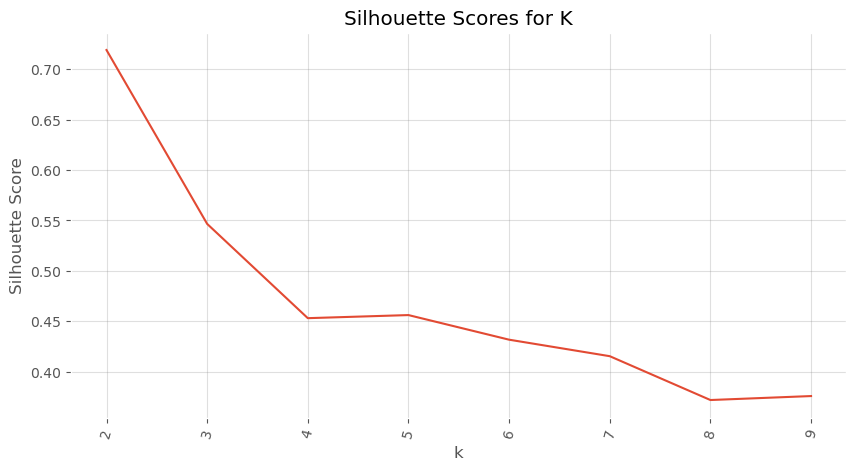

In [38]:
scaler, kmeans, train_regimes, train_feat = compute_regime_clusters(
    df_train,
    n_clusters=None,      # auto choose using silhouette
    atr_window=14,
    vol_windows=[20, 60]
)

In [39]:
df_train_macd =\
(
    assign_regimes(
        df_train,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)
df_train_macd

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,,,
2007-01-31,101.366928,101.634893,100.414956,100.577151,91868600,0.561016,1.0,0.006701,1.056196,1.0
2007-02-01,101.973335,102.008595,101.479725,101.648956,69312400,0.540518,1.0,0.005964,1.062514,1.0
2007-02-02,102.114395,102.213117,101.811181,102.057981,49607000,0.541905,1.0,0.001382,1.063984,1.0
2007-02-05,102.142586,102.206048,101.782947,102.036805,45705300,0.529519,1.0,0.000276,1.064278,1.0
2007-02-06,102.170746,102.269468,101.775858,102.227160,57081300,0.525925,1.0,0.000276,1.064571,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-02-02,357.220306,358.783831,352.323818,355.441466,64450700,0.574038,1.0,0.014041,3.722068,1.0
2021-02-03,357.501221,359.233261,356.218584,358.053596,52427100,0.616917,1.0,0.000786,3.724995,1.0
2021-02-04,361.564453,361.611253,357.613542,358.540405,47142600,0.569221,1.0,0.011302,3.767332,1.0


In [40]:
regimes = sorted(df_train_macd["regime"].unique())

regime_dfs = { r: df_train_macd[df_train_macd["regime"] == r].copy()
               for r in regimes }

In [41]:
regimes

[0.0, 1.0]

In [42]:
macd_vol_clustering_hyperparam_df =\
(
    run_macd_hyperparam_search_with_regimes(
        df = df_train_macd,
        price_col='Close',
        regimes = regimes,
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file="data/vol_clustering_with_macd.csv"
    )
)
macd_vol_clustering_hyperparam_df

,short_ma,long_ma,signal,regime,cumulative_return,sharpe
82,6,55,8,0.0,1.475943,0.356680
261,9,46,6,0.0,1.456667,0.344146
370,10,51,5,0.0,1.456667,0.344146
63,6,46,10,0.0,1.452825,0.346980
361,10,46,6,0.0,1.452825,0.346980
...,...,...,...,...,...,...
1727,16,33,16,1.0,1.144604,0.102168
1719,16,28,20,1.0,1.144345,0.102777
1907,20,28,16,1.0,1.144345,0.102777
1728,16,33,18,1.0,1.119205,0.085856


In [43]:
best_per_regime = (
    macd_vol_clustering_hyperparam_df
    .sort_values("cumulative_return", ascending=False)
    .groupby("regime")
    .head(1)
    .reset_index(drop=True)
)

print(best_per_regime)


   short_ma  long_ma  signal  regime  cumulative_return    sharpe
0        13       60       6     1.0           2.032481  0.561368
1         6       55       8     0.0           1.475943  0.356680


In [44]:
regime_macd_lookup = {
    row.regime: (row.short_ma, row.long_ma, row.signal)
    for _, row in best_per_regime.iterrows()
}

print(regime_macd_lookup)


{1.0: (13.0, 60.0, 6.0), 0.0: (6.0, 55.0, 8.0)}


In [45]:
vol_clustering_macd_test =\
(
    assign_regimes(
        df_test,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)

vol_clustering_macd_test.head()

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,,,
2021-05-06,393.632935,393.764422,388.570088,390.589579,74321400,0.582287,1.0,0.007954,1.077368,1.0
2021-05-07,396.497742,397.155264,393.717419,394.403119,67733800,0.596081,1.0,0.007252,1.085209,1.0
2021-05-10,392.571472,397.080106,392.449358,396.854683,81852400,0.623618,1.0,-0.009952,1.074462,1.0
2021-05-11,389.067841,390.063497,385.169747,388.025230,116888000,0.604912,1.0,-0.008965,1.064873,1.0
2021-05-12,380.802094,387.546269,379.477675,386.268833,134811000,0.616665,1.0,-0.021474,1.042250,1.0


In [46]:
for r in regimes:
    df_r = vol_clustering_macd_test[vol_clustering_macd_test["regime"] == r].copy()
    spans = regime_macd_lookup[r]
    df_r = MACD(df_r, spans, price_col='Close', allow_short=False)
    vol_clustering_macd_test.loc[df_r.index, f"signal_r{r}"] = df_r["signal"]

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0
Date,,,,,,,,,,,,
2021-05-06,393.632935,393.764422,388.570088,390.589579,74321400,0.582287,1.0,0.007954,1.077368,1.0,NaN,NaN
2021-05-07,396.497742,397.155264,393.717419,394.403119,67733800,0.596081,1.0,0.007252,1.085209,1.0,NaN,NaN
2021-05-10,392.571472,397.080106,392.449358,396.854683,81852400,0.623618,1.0,-0.009952,1.074462,1.0,NaN,0.0
2021-05-11,389.067841,390.063497,385.169747,388.025230,116888000,0.604912,1.0,-0.008965,1.064873,1.0,NaN,NaN
2021-05-12,380.802094,387.546269,379.477675,386.268833,134811000,0.616665,1.0,-0.021474,1.042250,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629,1.0,NaN,NaN
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435,1.0,NaN,NaN
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091,1.0,NaN,NaN


In [47]:
signal_cols = [col for col in vol_clustering_macd_test.columns if col.startswith("signal_r")]
signal_cols

['signal_r0.0', 'signal_r1.0']

In [48]:
vol_clustering_macd_test["signal"] =\
(
    vol_clustering_macd_test[signal_cols]
    .bfill(axis=1)
    .iloc[:, 0]
)

In [49]:
vol_clustering_macd_test = generate_position(vol_clustering_macd_test)

In [50]:
positions_df = vol_clustering_macd_test[['positions']].reset_index()

plot = (
    ggplot(positions_df, aes(x='Date', y='positions'))
    + geom_line(color='blue', size=1)
    + labs(
        title='Trading Positions Over Time',
        x='Date',
        y='Position',
        caption='1 = Long, 0 = No Position, -1 = Short'
    )
    + theme(legend_position='top')
    + ggsize(1200, 500)
)

plot.show()

In [51]:
vol_clustering_macd_test = compute_portfolio(
    vol_clustering_macd_test,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-06,393.632935,393.764422,388.570088,390.589579,74321400,0.582287,1.0,0.007954,1.077368,1.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-07,396.497742,397.155264,393.717419,394.403119,67733800,0.596081,1.0,0.007252,1.085209,1.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-10,392.571472,397.080106,392.449358,396.854683,81852400,0.623618,1.0,-0.009952,1.074462,1.0,...,0.0,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-11,389.067841,390.063497,385.169747,388.025230,116888000,0.604912,1.0,-0.008965,1.064873,1.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-12,380.802094,387.546269,379.477675,386.268833,134811000,0.616665,1.0,-0.021474,1.042250,1.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629,1.0,...,NaN,0.0,111111.078613,0.0,0.0,0.0,0.0,111111.078613,0.0,1.111111
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435,1.0,...,NaN,0.0,111111.078613,0.0,0.0,0.0,0.0,111111.078613,0.0,1.111111
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091,1.0,...,NaN,0.0,111111.078613,0.0,0.0,0.0,0.0,111111.078613,0.0,1.111111


In [52]:
(
    plot_cumulative_returns(
        df = vol_clustering_macd_test.reset_index(),
        date_column='Date',
        strategy_column = 'cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )  
)

In [53]:
vol_clustering_macd_metric = \
(
    compute_performance_metrics(
        log_returns=vol_clustering_macd_test['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
vol_clustering_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),0.024,0.106,0.165,0.274,0.408,0.143,111111.079,1.111


In [54]:
combined_results.append(vol_clustering_macd_metric)

## <a id = "part15"></a> 1.5 SMA (Tuned) [back to table of contents](#top) 


In [55]:
# original, overfitting suspected, removing it for now
# short_windows = np.arange(1,301)
# long_windows  = np.arange(1,301)
# momentum_tasks = [
#     (s, l)
#     for s in short_windows
#     for l in long_windows
#     if l > s
# ]

short_windows = range(3, 10)
ratio_values = np.arange(1.5,6.5,0.5)

momentum_tasks = [
    (s, int(s * r))
    for s in short_windows
    for r in ratio_values
]

len(momentum_tasks)

70

In [56]:
sma_tuned =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/sma_tuned_with_signal.csv",
        signal_check=True
    )
)

sma_tuned

Loaded cached Momentum results from: data/sma_tuned_with_signal.csv


,short_window,long_window,regime,cumulative_return,sharpe
0,7,10,NaN,4.275484,0.629640
1,3,4,NaN,4.252271,0.557656
2,6,12,NaN,4.247251,0.630437
3,9,13,NaN,4.117687,0.625098
4,4,16,NaN,4.101432,0.615816
...,...,...,...,...,...
65,9,18,NaN,3.097129,0.496781
66,4,22,NaN,3.053736,0.497431
67,6,24,NaN,2.985565,0.492102
68,3,7,NaN,2.974539,0.460962


In [57]:
best_momentum = sma_tuned.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(7.0, 10.0)

In [58]:
best_momentum_df=\
(
    SMA(
        df=df_test,
        windows=[int(best_short),int(best_long)]
    )
)
best_momentum_df =\
(
    compute_portfolio(
        best_momentum_df,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [59]:
momentum_hyperparam_metrics =\
(
    compute_performance_metrics(
        best_momentum_df['strategy_returns'],
        initial_capital=starting_capital,
        strategy='SMA'
    )
)
momentum_hyperparam_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
SMA,0.136,0.106,0.123,1.256,2.023,1.105,183489.142,1.835


In [60]:
combined_results.append(momentum_hyperparam_metrics)

## <a id = "part16"></a> 1.6 Dual MACD [back to table of contents](#top) 

In [61]:
fast_spans = [3, 10, 16]   
slow_spans = [12, 26, 9]

dual_macd =\
(
    DUAL_MACD(
        df=df_test,
        fast_spans=fast_spans,
        slow_spans=slow_spans,
        price_column="Close",
        allow_short=False,
    )
)

dual_macd.head(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,fast_ewma_short,fast_ewma_long,fast_macd,fast_signal,slow_ewma_short,slow_ewma_long,slow_macd,slow_signal,fast_cross_up,fast_cross_down,dual_macd_signal
Date,,,,,,,,,,,,,,,,,,,,
2021-02-09,365.365479,365.964682,364.354358,364.766275,35551100,0.561384,1.0,NaN,1.000000,365.365479,365.365479,0.000000,0.000000,365.365479,365.365479,0.000000,0.000000,False,False,NaN
2021-02-10,365.206451,367.266179,362.790978,367.116378,59154400,0.542513,1.0,-0.000435,0.999565,365.259460,365.278014,-0.018553,-0.009856,365.279339,365.282907,-0.003568,-0.001982,False,True,0.0
2021-02-11,365.796265,366.713785,363.352706,366.292468,42913300,0.551159,1.0,0.001614,1.001179,365.566206,365.486347,0.079859,0.023860,365.481095,365.467351,0.013744,0.004463,True,False,1.0
2021-02-12,367.603210,367.846612,364.916193,364.991108,50593300,0.533410,1.0,0.004928,1.006125,366.652608,366.183759,0.468849,0.156778,366.150964,366.064444,0.086520,0.032260,False,False,NaN
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,0.553147,1.0,-0.000866,1.005253,366.978927,366.499853,0.479074,0.238289,366.459037,366.347462,0.111576,0.055855,False,False,NaN


In [62]:
dual_macd = generate_position(
    dual_macd,
    signal_column='dual_macd_signal'
)
dual_macd = compute_portfolio(
    dual_macd,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)
dual_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,fast_ewma_short,...,dual_macd_signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.605946,1.0,-0.010787,1.834629,674.308719,...,NaN,0.0,133949.099792,0.0,0.0,0.0,0.0,133949.099792,0.0,1.339491
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.599819,1.0,0.000984,1.836435,672.639345,...,NaN,0.0,133949.099792,0.0,0.0,0.0,0.0,133949.099792,0.0,1.339491
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.576946,1.0,0.015484,1.865091,677.039674,...,NaN,0.0,133949.099792,0.0,0.0,0.0,0.0,133949.099792,0.0,1.339491
2025-11-11,683.000000,683.570007,678.729980,679.950012,58953400,0.610358,1.0,0.002287,1.869361,680.019837,...,NaN,0.0,133949.099792,0.0,0.0,0.0,0.0,133949.099792,0.0,1.339491
2025-11-12,683.380005,684.960022,680.950012,684.789978,62312500,0.608380,1.0,0.000556,1.870401,681.699921,...,NaN,0.0,133949.099792,0.0,0.0,0.0,0.0,133949.099792,0.0,1.339491


In [63]:
dual_macd_metrics = \
(
    compute_performance_metrics(
        log_returns=dual_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Dual MACD'
    )
)
print(dual_macd_metrics)


            CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Dual MACD  0.063       0.096         0.118         0.692          1.054   

           Calmar Ratio  Final Portfolio Value  Cumulative Return  
Dual MACD         0.535               133949.1              1.339  


In [64]:
(
    plot_cumulative_returns(
        df =dual_macd.reset_index(),
        passive_column='cumulative_passive_returns',
        strategy_column='cumulative_strategy_returns'
    )
)

In [65]:
combined_results.append(dual_macd_metrics)

## <a id = "part17"></a> 1.7 SL (Daily Returns) [back to table of contents](#top) 

In [66]:
return_period = 1
Y =\
(
    np
    .log(spy['Close']
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name = 'SPY_pred'

Y

Date
2006-11-01   -0.000585
2006-11-02   -0.001756
2006-11-03    0.011216
2006-11-06    0.003831
2006-11-07    0.002161
                ...   
2025-11-06    0.000984
2025-11-07    0.015484
2025-11-10    0.002287
2025-11-11    0.000556
2025-11-12         NaN
Name: SPY_pred, Length: 4788, dtype: float64

In [67]:
lag_periods = [i for i in range(1,11)]
vol_periods = [5,10,20,60,120]
sma_periods = [63]
ema_periods = [10,30]
rsi_periods = [10,30]
stok_periods = [30]
stod_periods = [30]
roc_periods = [30]
atr_periods = [5, 14, 21]


X = create_all_features(
    spy,
    price_column='Close',
    lagged_return_periods=lag_periods,
    vol_periods=vol_periods,
    sma_periods=sma_periods,
    ema_periods=ema_periods,
    rsi_periods=rsi_periods,
    stok_periods=stok_periods,
    stod_periods=stod_periods,
    roc_periods=roc_periods,
    atr_periods=atr_periods
)

X

,1DT,2DT,3DT,4DT,5DT,6DT,7DT,8DT,9DT,10DT,...,EMA10,EMA30,RSI10,RSI30,%K30,%D30,ROC30,ATR5,ATR14,ATR21
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.973618,95.973618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,-0.000585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.963414,95.969997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,-0.001756,-0.002341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.924461,95.955750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,0.011216,0.009460,0.008875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96.088952,96.012099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,0.003831,0.015048,0.013291,0.012706,NaN,NaN,NaN,NaN,NaN,NaN,...,96.291119,96.088794,NaN,NaN,NaN,NaN,NaN,0.943897,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,-0.010787,-0.007328,-0.019252,-0.017377,-0.014103,-0.025162,-0.024681,-0.022029,-0.010300,-0.002161,...,676.950233,670.954578,48.347481,55.109778,47.395490,58.428242,1.282825,7.202014,6.708575,8.335717
2025-11-07,0.000984,-0.009803,-0.006344,-0.018268,-0.016393,-0.013118,-0.024177,-0.023697,-0.021045,-0.009316,...,675.862912,670.955571,41.999990,53.903012,49.185977,54.566765,1.098418,8.008008,6.855002,8.580479
2025-11-10,0.015484,0.016468,0.005681,0.009140,-0.002784,-0.000909,0.002365,-0.008694,-0.008213,-0.005561,...,676.876929,671.631986,45.513994,57.001951,77.590849,58.057439,2.290674,9.078015,7.440717,8.109052


In [68]:
data =\
(
    pd
    .concat([Y, X],
            axis = 1)
    .dropna()
)

Y =\
(
    data
    .loc[ : , Y.name]
)
X =\
(
    data
    .loc[ : , X.columns]
)

In [69]:
SL =\
(
    SupervisedLearning()
)

In [70]:
X_train, X_test, Y_train, Y_test =\
(
    SL
    .sequential_split(X,Y,train_frac=0.75)
    
)

Sequential Split: 3501 train / 1167 test samples


In [71]:
seed = 2025
num_folds = 10

metric = "neg_mean_squared_error"

In [72]:
comparison_df = None;
cache_file = "data/sl_prediction_comparison.csv"

if os.path.exists(cache_file):
    comparison_df = pd.read_csv(cache_file)
else :
    results =\
    (
        SL
        .run_all_models(
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test,
            num_folds = num_folds,
            seed = seed,
            metric = metric
        )
    )
    results['comparison_df'].to_csv(cache_file)
    comparison_df = results['comparison_df']

In [73]:
(
    SL
    .plot_performance(comparison_df)
)

In [74]:
# chosen model
model =\
(
    SL.get_model_by_name("Support Vector Machine")
)

model

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [76]:
testing_df =\
(
    spy
    .copy()
    .rename(columns={'Close': "actual_close"})
)
testing_df.loc[X_test.index, "pred_return"] = y_pred
testing_df["pred_close"] =\
(
    testing_df["actual_close"] 
    * np.exp(testing_df["pred_return"])
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close
Date,,,,,,,
2006-11-01,95.973618,96.990434,95.875442,96.927323,83005600,NaN,NaN
2006-11-02,95.917496,96.078781,95.622970,95.728154,60693100,NaN,NaN
2006-11-03,95.749176,96.345246,95.104024,96.261099,71346400,NaN,NaN
2006-11-06,96.829163,96.969411,96.036742,96.043761,63303300,NaN,NaN
2006-11-07,97.200867,97.460327,96.773101,96.913350,63318900,NaN,NaN
...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.007020,675.032202
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.007019,675.696130
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,0.007024,686.243610


In [77]:
def generate_signal_simple(df: pd.DataFrame):
    df = df.copy()
    df['signal'] = (df['pred_return'] > 0).astype(int)

    df['positions'] = df['signal'] 
    # no need to shift(1) cause we using predicted returns
    return df

In [78]:
def compute_cumulative_returns(df, 
                       position_column = 'positions',
                       price_column = 'Close'):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df[price_column]
            /
            df[price_column].shift(1)
            )
    )

    df['strategy_returns'] =\
    (
        df[position_column].shift(1)
        *
        df['passive_returns']
    )

    df['cum_log_returns'] =\
    (
        df['strategy_returns']
        .cumsum()
    )

    df['cumulative_returns_strategy'] =\
    (
        np.exp(
            df['cum_log_returns']
        )
    )

    df['cumulative_max_strategy'] =\
    (
        df['cumulative_returns_strategy']
        .cummax()
    )

    df['cumulative_returns_passive'] =\
    (
        np.exp(
            df['passive_returns']
            .cumsum()
        )
    )
    return df

In [79]:
testing_df =\
(
    generate_signal_simple(testing_df)
    .dropna()
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions
Date,,,,,,,,,
2021-03-23,365.857697,369.577320,365.068687,368.121415,90686600,-0.011807,361.563454,0,0
2021-03-24,363.997894,368.910449,363.950941,367.266672,97588600,-0.011530,359.825172,0,0
2021-03-25,366.045624,366.844007,360.597661,362.551423,116128600,-0.011525,361.851254,0,0
2021-03-26,371.944427,372.348320,366.599802,367.200940,114409100,-0.011809,367.577893,0,0
2021-03-29,371.756592,372.667715,368.966866,370.460352,108107600,-0.011597,367.470294,0,0
...,...,...,...,...,...,...,...,...,...
2025-11-05,677.580017,680.859985,674.169983,674.979980,74402400,0.007025,682.356623,1,1
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.007020,675.032202,1,1
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.007019,675.696130,1,1


In [80]:
testing_df =\
(
    compute_cumulative_returns(
        df = testing_df,
        position_column='positions',
        price_column = 'actual_close'
    )
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions,passive_returns,strategy_returns,cum_log_returns,cumulative_returns_strategy,cumulative_max_strategy,cumulative_returns_passive
Date,,,,,,,,,,,,,,,
2021-03-23,365.857697,369.577320,365.068687,368.121415,90686600,-0.011807,361.563454,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-24,363.997894,368.910449,363.950941,367.266672,97588600,-0.011530,359.825172,0,0,-0.005096,-0.000000,0.000000,1.000000,1.00000,0.994917
2021-03-25,366.045624,366.844007,360.597661,362.551423,116128600,-0.011525,361.851254,0,0,0.005610,0.000000,0.000000,1.000000,1.00000,1.000514
2021-03-26,371.944427,372.348320,366.599802,367.200940,114409100,-0.011809,367.577893,0,0,0.015986,0.000000,0.000000,1.000000,1.00000,1.016637
2021-03-29,371.756592,372.667715,368.966866,370.460352,108107600,-0.011597,367.470294,0,0,-0.000505,-0.000000,0.000000,1.000000,1.00000,1.016123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,677.580017,680.859985,674.169983,674.979980,74402400,0.007025,682.356623,1,1,0.003459,0.003459,0.361140,1.434965,1.45574,1.852032
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,0.007020,675.032202,1,1,-0.010787,-0.010787,0.350353,1.419568,1.45574,1.832160
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,0.007019,675.696130,1,1,0.000984,0.000984,0.351337,1.420966,1.45574,1.833964


<Axes: xlabel='Date'>

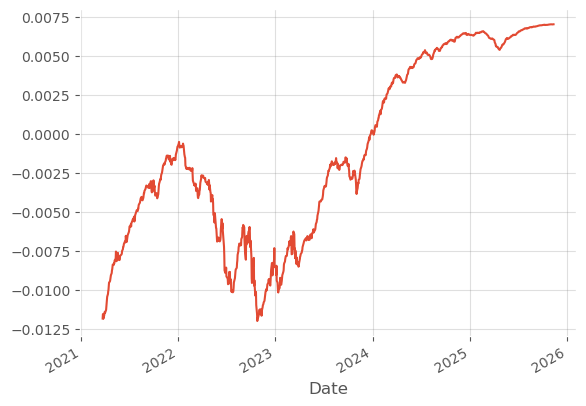

In [81]:
testing_df['pred_return'].plot()

In [82]:
ml_pred_returns_metrics =\
(
    compute_performance_metrics(
        log_returns=testing_df['strategy_returns'],
        initial_capital=100_000,
        strategy='ML (Predict Returns)'
    )
)

ml_pred_returns_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
ML (Predict Returns),0.083,0.106,0.188,0.808,1.255,0.442,144644.301,1.446


In [83]:
combined_results.append(ml_pred_returns_metrics)

## <a id = "part18"></a> 1.8 EMA (tuned) [back to table of contents](#top)

In [84]:
short_windows = range(3, 30)
ratio_values = np.arange(1.5,6.5,0.5)

momentum_tasks = [
    (s, int(s * r))
    for s in short_windows
    for r in ratio_values
]

len(momentum_tasks)

270

In [85]:
momentum_ema_tuned =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/ema_tuned.csv",
        ma_type='EMA',
        signal_check=False
    )
)

momentum_ema_tuned

Loaded cached Momentum results from: data/ema_tuned.csv


,short_window,long_window,regime,cumulative_return,sharpe
0,22,44,NaN,3.853735,0.792739
1,25,37,NaN,3.829979,0.791216
2,24,36,NaN,3.817847,0.791800
3,26,39,NaN,3.811441,0.787735
4,23,46,NaN,3.796392,0.783881
...,...,...,...,...,...
265,11,22,NaN,1.854221,0.381276
266,5,30,NaN,1.848951,0.374308
267,6,21,NaN,1.833821,0.370697
268,4,24,NaN,1.816363,0.367365


In [86]:
best_momentum = momentum_ema_tuned.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(22.0, 44.0)

In [87]:
best_ema_df =\
(
    EMA(
        df=df_test,
        windows=[int(best_short),int(best_long)],
        signal_check=True
    )
)
best_ema_df =\
(
    compute_portfolio(
        best_ema_df,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [88]:
ema_metrics =\
(
    compute_performance_metrics(
        best_ema_df['strategy_returns'],
        initial_capital=starting_capital,
        strategy='EMA'
    )
)
ema_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
EMA,0.089,0.129,0.27,0.731,1.128,0.331,150208.048,1.502


In [89]:
combined_results.append(ema_metrics)

## 👇 <a id = "part2"></a><font color = blue> 👉 Part 2 - Results of Strategies </font> [back to table of contents](#top)

In [90]:
comparison_df=\
(
    pd.concat(
        combined_results,
        axis=0
    )
    .sort_values(by='Final Portfolio Value', ascending=False)
)

comparison_df

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
Buy and Hold,0.141,0.173,0.245,0.850,1.403,0.574,187040.113,1.870
MACD (Tuned),0.139,0.173,0.245,0.843,1.391,0.569,185891.288,1.859
SMA,0.136,0.106,0.123,1.256,2.023,1.105,183489.142,1.835
EMA,0.089,0.129,0.270,0.731,1.128,0.331,150208.048,1.502
ML (Predict Returns),0.083,0.106,0.188,0.808,1.255,0.442,144644.301,1.446
Dual MACD,0.063,0.096,0.118,0.692,1.054,0.535,133949.100,1.339
MACD (Base),0.043,0.107,0.164,0.449,0.671,0.264,122363.859,1.224
MACD (Hyperparams),0.024,0.106,0.165,0.274,0.408,0.143,111111.079,1.111


In [91]:
print(comparison_df['Cumulative Return'])

Buy and Hold            1.870
MACD (Tuned)            1.859
SMA                     1.835
EMA                     1.502
ML (Predict Returns)    1.446
Dual MACD               1.339
MACD (Base)             1.224
MACD (Hyperparams)      1.111
Name: Cumulative Return, dtype: float64


In [92]:
comparison_df.index

Index(['Buy and Hold', 'MACD (Tuned)', 'SMA', 'EMA', 'ML (Predict Returns)',
       'Dual MACD', 'MACD (Base)', 'MACD (Hyperparams)'],
      dtype='object')

## 👇 <a id = "part3"></a><font color = blue> Part 3 - Executive Summary</font> [back to table of contents](#top)

write summary hereeee

## 👇 <a id = "part4"></a><font color = blue> Part 4 - Self-Critique</font> [back to table of contents](#top)

self critique

## 👇 <a id = "part4"></a><font color = blue> Part 5 - Contribution Statement</font> [back to table of contents](#top)

Contribution Statement
